In [1]:
#import libraries
import os
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.models import Model
from keras.layers import Input, concatenate, Flatten, Dense, Attention, Multiply, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

2024-01-30 03:23:14.771141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 03:23:16.208012: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import zipfile

f = zipfile.ZipFile("B_test.zip",'r') # 压缩文件在jupyter中的位置
for file in f.namelist():
    f.extract(file,"")               # 解压到的位置
f.close()

In [3]:
# Data preparation
dataset_dir= 'B_test'
input_shape=(224, 224, 3)
batch_size=4

In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

In [5]:
test_datagen=ImageDataGenerator(
    rescale=1./255)

In [6]:
# #Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary' 
)

Found 2930 images belonging to 2 classes.
Found 732 images belonging to 2 classes.
Found 3662 images belonging to 2 classes.


In [7]:
#Ensemble Model using pre-trained model

# Load pre-trained models
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained models
for layer in resnet_model.layers:
    layer.trainable = False

for layer in vgg_model.layers:
    layer.trainable = False

2024-01-30 03:25:07.661816: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10229 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:89:00.0, compute capability: 8.6


94765736/94765736 [==============================] - 4s 0us/step


In [8]:
# 假设 resnet_model 和 vgg_model 是你的预训练模型

input_layer = Input(shape=(224, 224, 3))
resnet_features = resnet_model(input_layer)
vgg_features = vgg_model(input_layer)

merged = concatenate([resnet_features, vgg_features])
flatten = Flatten()(merged)
dense1 = Dense(512, activation='relu')(flatten)
output_layer = Dense(1, activation='sigmoid')(dense1)

ensemble_model = Model(inputs=input_layer, outputs=output_layer)


ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_3[0][0]']             
                                                          2                                       
                                                                                                  
 vgg16 (Functional)          (None, 7, 7, 512)            1471468   ['input_3[0][0]']             
                                                          8                                       
                                                                                              

In [9]:
# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=50, validation_data=(validation_generator), verbose=1)

Epoch 1/50


2024-01-30 03:25:20.824837: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8900
2024-01-30 03:25:22.068735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-30 03:25:23.399742: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc3b0095780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-30 03:25:23.399781: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2024-01-30 03:25:23.406104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-30 03:25:23.565070: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

733/733 [==============================] - 62s 73ms/step - loss: 0.6277 - accuracy: 0.8324 - val_loss: 0.2650 - val_accuracy: 0.9126
Epoch 2/50
733/733 [==============================] - 51s 69ms/step - loss: 0.2846 - accuracy: 0.8932 - val_loss: 0.2949 - val_accuracy: 0.8893
Epoch 3/50
733/733 [==============================] - 53s 72ms/step - loss: 0.2578 - accuracy: 0.9085 - val_loss: 0.2166 - val_accuracy: 0.9153
Epoch 4/50
733/733 [==============================] - 51s 70ms/step - loss: 0.2681 - accuracy: 0.8945 - val_loss: 0.2005 - val_accuracy: 0.9235
Epoch 5/50
733/733 [==============================] - 52s 70ms/step - loss: 0.2419 - accuracy: 0.9137 - val_loss: 0.2028 - val_accuracy: 0.9167
Epoch 6/50
733/733 [==============================] - 52s 71ms/step - loss: 0.2321 - accuracy: 0.9154 - val_loss: 0.2027 - val_accuracy: 0.9167
Epoch 7/50
733/733 [==============================] - 51s 70ms/step - loss: 0.2393 - accuracy: 0.9082 - val_loss: 0.2726 - val_accuracy: 0.8811
Epo

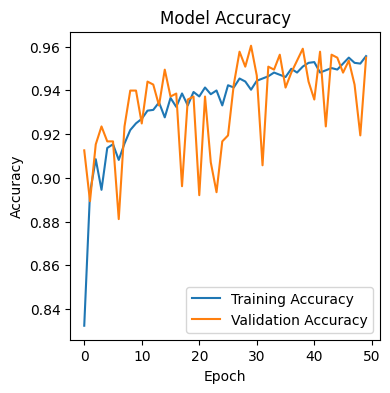

In [11]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

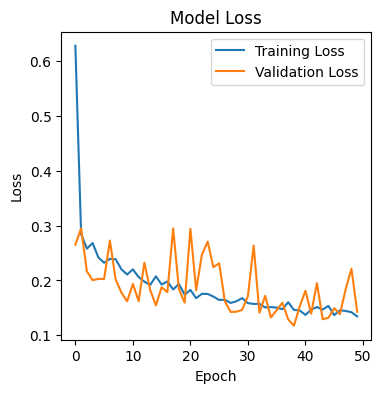

In [12]:
#Trainig loss and validation loss graph
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [13]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

916/916 [==============================] - 33s 36ms/step - loss: 0.1809 - accuracy: 0.9358
Test loss: 0.1808931678533554
Test accuracy: 0.9358274340629578


In [14]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

# Generate predictions for the test dataset
y_pred = ensemble_model.predict(test_generator)

916/916 [==============================] - 31s 32ms/step


In [15]:
print(y_pred)
print(test_generator.classes)

[[0.04851104]
 [0.05128324]
 [0.3716341 ]
 ...
 [0.9866297 ]
 [0.9985707 ]
 [0.99584323]]
[0 0 0 ... 1 1 1]


Binary Predictions:
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
Confusion Matrix:
[[1645  212]
 [  23 1782]]


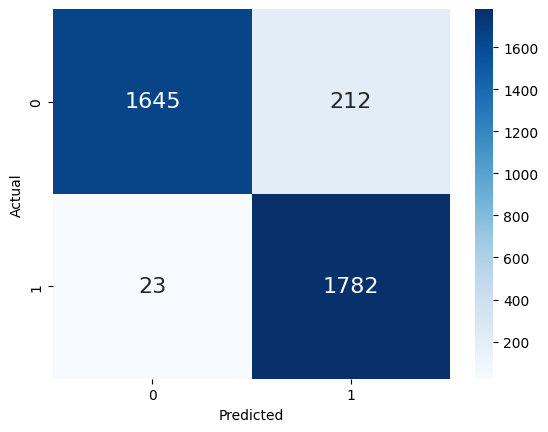

In [17]:
import numpy as np
import seaborn as sns
# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)

# 打印转换后的二分类预测结果
print("Binary Predictions:")
print(y_pred_binary)

# 计算混淆矩阵
cm = confusion_matrix(test_generator.classes, y_pred_binary)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用Seaborn绘制热力图
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
# 获取一个批次的训练数据和标签
x_train_batch, y_train_batch = next(train_generator)

# 获取一个批次的验证数据和标签
x_val_batch, y_val_batch = next(validation_generator)

# 获取一个批次的测试数据和标签
x_test_batch, y_test_batch = next(test_generator)

# 打印训练数据和标签
print("Training Data Shape:", x_train_batch.shape)
print("Training Labels:", y_train_batch)

# 打印验证数据和标签
print("Validation Data Shape:", x_val_batch.shape)
print("Validation Labels:", y_val_batch)

# 打印测试数据和标签
print("Test Data Shape:", x_test_batch.shape)
print("Test Labels:", y_test_batch)


Training Data Shape: (4, 224, 224, 3)
Training Labels: [0. 0. 0. 1.]
Validation Data Shape: (4, 224, 224, 3)
Validation Labels: [0. 0. 0. 0.]
Test Data Shape: (4, 224, 224, 3)
Test Labels: [0. 0. 0. 0.]


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# 获取真实标签
y_true = test_generator.classes

# 计算精确度、召回率和F1得分
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8936810431293881
Recall: 0.9872576177285318
F1 Score: 0.9381416162147933


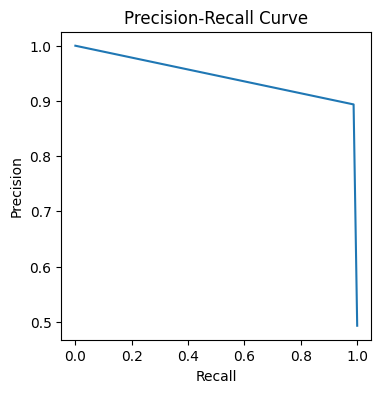

In [20]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_binary)

#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [21]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)

#compute the AUC score
roc_auc= auc(fpr, tpr)

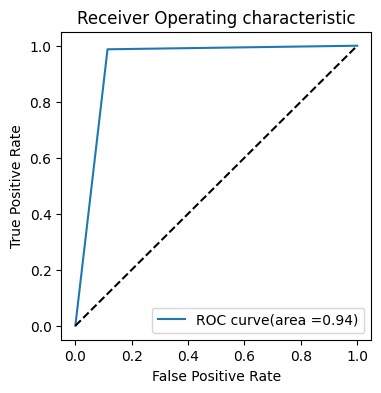

In [22]:
#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [23]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9872576177285318
specificity: 0.8858373721055466


In [24]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model

In [25]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()

ModuleNotFoundError: No module named 'numba'